In [1]:
import warnings
warnings.filterwarnings('ignore')
import time

- Importation des modules
- Chargement du fichier de données et retraitement du fichier de données
- Transformation du DataFrame des MetaDonnée en Matrice

In [2]:
import pandas as pd
import numpy as np
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from numba import jit

df = pd.read_csv("Data_Satisfaction_retraitement2.csv")

df = df.drop("Unnamed: 0",axis=1)
df = df.dropna(axis = 0, how = "all", subset =["Commentaires_reduit"])

y = df["star"]
Meta_Matrix = df.drop(["star","Commentaires_reduit"], axis =1).to_numpy()

Importation du model WordEmbedding pré-entrainé

In [3]:
Comments_tokens = [text.split() for text in df["Commentaires_reduit"]]
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-200")

Vectorization des commentaires en se basant sur la moyenne des vecteurs mots obtenus via vectorisation par le model.

In [4]:
@jit
def get_mean_vector(w2v_vectors, words):
    words = [word for word in words if word in w2v_vectors]
    if words:
        avg_vector = np.mean(w2v_vectors[words], axis=0)
    else:
        avg_vector = np.zeros_like(w2v_vectors['hi'])
    return avg_vector

@jit
def fit_w2v_avg(w2v_vectors,X_train_tokens):
    X_vectors = np.array([get_mean_vector(w2v_vectors, words)
                                for words in X_train_tokens])
    return X_vectors
    
Com_Matrix = fit_w2v_avg(model,Comments_tokens)
X = np.concatenate([Com_Matrix,Meta_Matrix],axis=1)
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 100)

Application Algorithme de GridSearch sur les modeles : GradientBoosting, RandomForest, et SVC

In [5]:
@jit
def modelisation(X_train,X_test):
    gb = GradientBoostingClassifier()
    rf = RandomForestClassifier()
    svc = SVC()

    param_grid_gb = {"n_estimators":[100,150,200], "learning_rate":[0.5,1.0,1.5], "max_depth": [1,2,3],"random_state" : [100] }
    param_grid_svc = {'C':[0.1,1,10,30],"kernel" :["linear", "poly", "rbf", "sigmoid"],"random_state" : [100] }
    param_grid_rf = {'max_features': ["sqrt", "log2", None ],"random_state" : [100] }

    gridcvs = {}
    for pgrid, clf, name in zip((param_grid_gb, param_grid_rf, param_grid_svc),
                                (gb, rf, svc),
                                ('GB', 'RF', 'SVM')):
        gcv = GridSearchCV(clf, pgrid, cv=5, n_jobs = -1, refit=True).fit(X_train,y_train)
        gridcvs[name] = gcv
    return gridcvs 

In [6]:
start = time.time()
my_grid = modelisation(X_train,X_test)
end = time.time()
print("duration=", end - start)

duration= 7512.034269809723


Affichage des meilleurs parametres ainsi que des meilleurs score de précisions par models

In [7]:
print(my_grid["GB"].best_params_)
print(my_grid["RF"].best_params_)
print(my_grid["SVM"].best_params_)

{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 200, 'random_state': 100}
{'max_features': None, 'random_state': 100}
{'C': 1, 'kernel': 'rbf', 'random_state': 100}


In [8]:
print(my_grid["GB"].best_score_)
print(my_grid["RF"].best_score_)
print(my_grid["SVM"].best_score_)

0.69179347397969
0.6787921704019237
0.6823237452464023


Application Algorithme de GridSearch sur le modèle de régression logistique

In [9]:
from sklearn import linear_model 
from sklearn import model_selection
from sklearn.model_selection import train_test_split

rl = linear_model.LogisticRegression()
param_grid_rl = { 'C':[0.1,1,10,30], 'max_iter' : [100,300,1000], "random_state" : [100]}
grid_rl = model_selection.GridSearchCV(estimator=rl, param_grid= param_grid_rl )
grid_rl.fit(X_train, y_train)

print(grid_rl.best_params_)
print(grid_rl .best_score_) 

{'C': 1, 'max_iter': 1000, 'random_state': 100}
0.6806708244501157


Application du model ayant eu la meilleur précision sur les données d'entrainement au set de test.

In [10]:
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5, max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test,y_test)

0.6883077847911031

Création d'un réseau de neurone

In [11]:
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model

In [12]:
y = y.replace(to_replace = [1,2,3,4,5], value = [0,1,2,3,4])
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 100)

In [13]:
X_train_dim = X_train.shape[1]
inputs = Input(shape = X_train_dim, name = "Input")
couche={}
n = 3
for i in range(1,n+1):
    if i !=n:
        couche[i] = Dense(units = X_train_dim-i*(X_train_dim//n), activation = "tanh", name = "Dense_"+str(i))
    else:
        couche[i] = Dense(units = 5, activation = "softmax", name = "Dense_"+str(i))

x=couche[1](inputs)
for i in range(2,n):   
    x=couche[i](x)
outputs=couche[n](x)
    

model = Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 211)]             0         
                                                                 
 Dense_1 (Dense)             (None, 141)               29892     
                                                                 
 Dense_2 (Dense)             (None, 71)                10082     
                                                                 
 Dense_3 (Dense)             (None, 5)                 360       
                                                                 
Total params: 40,334
Trainable params: 40,334
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor = 'val_accuracy',
                        min_delta = 0.001,
                        patience = 10,
                        factor = 0.5, 
                        cooldown = 10,
                        verbose = 1)


from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor = 'val_accuracy',
                    min_delta = 0.0001,
                    patience = 30,
                    verbose = 1,
                    restore_best_weights = True)

In [15]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])
model_history = model.fit(X_train,y_train,epochs=500,batch_size=150,validation_split=0.1, callbacks = [reducelr, earlystop])

Epoch 1/500
80/80 [==============================] - 1s 4ms/step - loss: 0.9805 - accuracy: 0.6413 - val_loss: 0.8842 - val_accuracy: 0.6529 - lr: 0.0010
Epoch 2/500
80/80 [==============================] - 0s 2ms/step - loss: 0.8393 - accuracy: 0.6782 - val_loss: 0.8558 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.8216 - accuracy: 0.6851 - val_loss: 0.8521 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 4/500
80/80 [==============================] - 0s 1ms/step - loss: 0.8131 - accuracy: 0.6839 - val_loss: 0.8494 - val_accuracy: 0.6754 - lr: 0.0010
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.8047 - accuracy: 0.6903 - val_loss: 0.8584 - val_accuracy: 0.6619 - lr: 0.0010
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.8042 - accuracy: 0.6917 - val_loss: 0.8509 - val_accuracy: 0.6642 - lr: 0.0010
Epoch 7/500
80/80 [==============================] - 0s 2ms/step - loss: 0.7

Epoch 51/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6583 - accuracy: 0.7553 - val_loss: 0.8453 - val_accuracy: 0.6814 - lr: 2.5000e-04
Epoch 52/500
80/80 [==============================] - 0s 1ms/step - loss: 0.6569 - accuracy: 0.7575 - val_loss: 0.8460 - val_accuracy: 0.6777 - lr: 2.5000e-04
Epoch 53/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.7556 - val_loss: 0.8463 - val_accuracy: 0.6829 - lr: 2.5000e-04
Epoch 54/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6537 - accuracy: 0.7582 - val_loss: 0.8452 - val_accuracy: 0.6875 - lr: 2.5000e-04
Epoch 55/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6515 - accuracy: 0.7587 - val_loss: 0.8432 - val_accuracy: 0.6860 - lr: 2.5000e-04
Epoch 56/500
80/80 [==============================] - 0s 2ms/step - loss: 0.6502 - accuracy: 0.7571 - val_loss: 0.8461 - val_accuracy: 0.6852 - lr: 2.5000e-04
Epoch 57/500
80/80 [==========================

80/80 [==============================] - 0s 1ms/step - loss: 0.6000 - accuracy: 0.7800 - val_loss: 0.8596 - val_accuracy: 0.6844 - lr: 6.2500e-05
Epoch 101/500
80/80 [==============================] - 0s 1ms/step - loss: 0.5997 - accuracy: 0.7822 - val_loss: 0.8591 - val_accuracy: 0.6867 - lr: 6.2500e-05
Epoch 102/500
80/80 [==============================] - 0s 2ms/step - loss: 0.5992 - accuracy: 0.7823 - val_loss: 0.8614 - val_accuracy: 0.6844 - lr: 6.2500e-05
Epoch 103/500
80/80 [==============================] - 0s 2ms/step - loss: 0.5988 - accuracy: 0.7816 - val_loss: 0.8615 - val_accuracy: 0.6814 - lr: 6.2500e-05
Epoch 104/500
80/80 [==============================] - 0s 1ms/step - loss: 0.5985 - accuracy: 0.7804 - val_loss: 0.8606 - val_accuracy: 0.6822 - lr: 6.2500e-05
Epoch 105/500
80/80 [==============================] - 0s 2ms/step - loss: 0.5980 - accuracy: 0.7819 - val_loss: 0.8610 - val_accuracy: 0.6829 - lr: 6.2500e-05
Epoch 106/500
80/80 [==============================] -

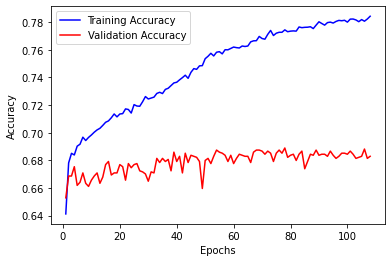

In [16]:
import matplotlib.pyplot as plt

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.legend()
plt.show()

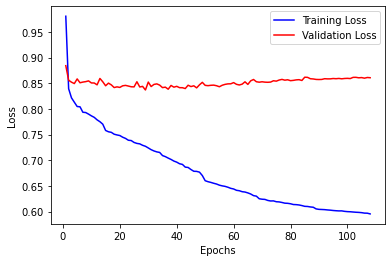

In [19]:

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['loss'],
         label = 'Training Loss',
         color = 'blue')

plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['val_loss'], 
         label = 'Validation Loss',
         color = 'red')

plt.legend()
plt.show()

Estimation de la performance du reseau de neurone

In [17]:
test_pred = model.predict(X_test)

y_test_class = y_test
y_pred_class = np.argmax(test_pred,axis=1)


104/104 [==============================] - 0s 758us/step


In [18]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class)) 

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       964
           1       0.21      0.11      0.15       248
           2       0.30      0.23      0.26       316
           3       0.44      0.46      0.45       628
           4       0.81      0.83      0.82      1171

    accuracy                           0.67      3327
   macro avg       0.51      0.51      0.50      3327
weighted avg       0.64      0.67      0.65      3327

[[868  19  26  38  13]
 [ 95  28  47  66  12]
 [ 41  38  72 139  26]
 [ 41  34  78 292 183]
 [ 40  14  20 129 968]]
